In [165]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)

#Tensorflow
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Pandas
import pandas as pd 

#Keras
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Statistics Libraries
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import math as m

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SKlearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

#global
import os, glob

In [166]:
import warnings
warnings.filterwarnings("ignore")

In [167]:
ID = "03"
MODEL_NAME = "C-LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Class"
FRECUENCIA = "1D"
ACC_RESULT = 0

In [168]:
RANGE = 5

HYPER_L1_IN = RANGE
EPOCHS = 150
BATCH_SIZE = 32

TEST_SIZE = .20
VAL_SIZE = .10

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [169]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

C-EURUSD_FULL_1D_21F.csv
C-EURUSD_FULL_1H_25F.csv
C-EURUSD_FULL_1H_54F.csv


In [170]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[0], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,0.00026,Friday,4,0.000787,0.000787,0.000000,0.0,0.0,0.0,2.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,...,0.00010,Sunday,6,0.003862,0.003075,0.000000,0.0,0.0,0.0,2.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,...,0.00010,Monday,0,0.004053,0.000191,0.000000,0.0,0.0,0.0,1.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,...,0.00010,Tuesday,1,0.002523,-0.001530,1.263726,0.0,0.0,0.0,-2.0


In [171]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 21)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05   
std       0.122817     0.123571     0.121969     0.122813  5.305200e+05   
min  

In [173]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 19)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  Spread  weekday  Pct_Range_Close  \
0  1.22791    1.23169  1291823.750  0.0001        4        -0.003680   
1  1.22955    1.23099    93508.000  0.0001        6        -0.000568   
2  1.21298    1.21486  1348137.000  0.0001        0        -0.013102   
3  1.20583    1.20701  1344214.000  0.0001        1        -0.006461   
4  1.20504    1.20784  1355827.375  0.0001        2         0.000688   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  \
0             -0.005690   

In [174]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [175]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
NUM_FEATURES = DF_Full.shape[1]
print(DF_Full.shape)

(4938, 19)


In [176]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  5137


In [177]:
DF_Full[TARGET_NAME][0:12]

0     0.0
1    -2.0
2    -2.0
3     0.0
4     1.0
5    -2.0
6     0.0
7     1.0
8     2.0
9     1.0
10   -1.0
11   -2.0
Name: Class, dtype: float64

### Generate VECTOR Y

In [178]:
#generate the VECTOR Y
uniques, ids = np.unique(DF_Full[TARGET_NAME], return_inverse=True)

#target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)
target_y = np_utils.to_categorical(ids,len(uniques))
print(ids)
print(uniques)
print(target_y)

[2 0 0 ... 3 3 2]
[-2. -1.  0.  1.  2.]
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [179]:
close_y = target_y
print(close_y[:10])   
#   [1. 0. 0. 0. 0.]   =  0
#   [0. 1. 0. 0. 0.]   =  1
#   [0. 0. 1. 0. 0.]   =   2 
#   [0. 0. 0. 1. 0.]   =  -2
#   [0. 0. 0. 0. 1.]   =  -1
close_y.shape

[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


(4938, 5)

### REMOVE COLUMNS 

In [180]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full = DF_Full.drop(['Buy'], axis = 1)
DF_Full = DF_Full.drop(['Buy2'], axis = 1)
DF_Full = DF_Full.drop(['Sell'], axis = 1)
DF_Full = DF_Full.drop(['Sell2'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(4938, 19)


KeyError: "['Buy'] not found in axis"

### SPLIT in 3 Sub Datasets

In [181]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 1541
end of train:  3596
count val:  513
count test:  1027
end_val 4109


In [182]:
close_y[:end_train,:]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [183]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3596, 18)
data_val.shape:  (513, 18)
data_test.shape:  (829, 18)
data_training_y.shape:  (3596, 5)
data_val_y.shape:  (513, 5)
data_test_y.shape:  (829, 5)


In [184]:
data_test['Close'].head(10)

4109    1.17336
4110    1.17427
4111    1.17414
4112    1.18138
4113    1.18644
4114    1.18314
4115    1.18223
4116    1.18149
4117    1.17948
4118    1.17716
Name: Close, dtype: float64

In [185]:
uniques_data_test_y = uniques[data_test_y.argmax(1)]
uniques_data_test_y[:10]

array([ 1.,  0.,  2.,  2., -1., -1.,  0., -1., -1.,  1.])

### SCALAR

In [186]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[3.44231014e-01 3.38946608e-01 3.34382014e-01 ... 2.93641673e-01
  2.95892119e-01 2.87029679e-01]
 [3.35199084e-01 3.28539163e-01 3.37436067e-01 ... 2.95356093e-01
  2.96474298e-01 2.86726581e-01]
 [3.34871972e-01 3.26967206e-01 3.06950730e-01 ... 2.95701015e-01
  2.96351066e-01 2.86225730e-01]
 ...
 [1.53597325e-01 1.49643148e-01 1.38278692e-01 ... 6.00533062e-02
  2.91191702e-02 9.58731573e-05]
 [1.39604194e-01 1.35043816e-01 1.38609854e-01 ... 6.24364050e-02
  3.05516901e-02 1.16318397e-04]
 [1.36732877e-01 1.32532297e-01 1.22456489e-01 ... 6.44557676e-02
  3.19166576e-02 8.55927826e-05]]


(3596, 18)
[0.37669362 0.42690746 0.22466157 0.33182137 0.44717204 0.47414792
 0.30587499 0.43527102 0.48605834 0.61154273]


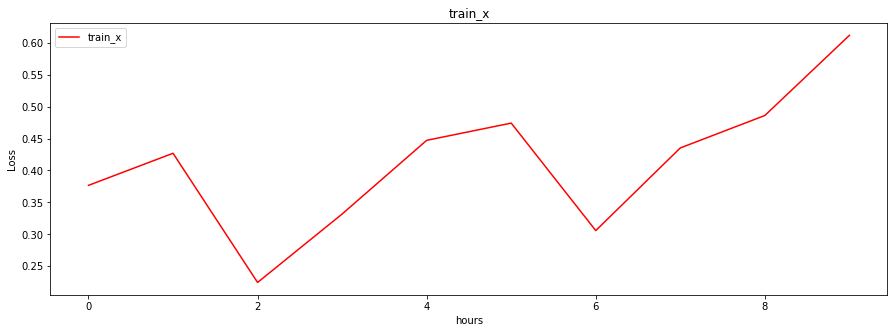

In [187]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [188]:
data_training_y[:10]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

### CHART MA's

(3596, 18)


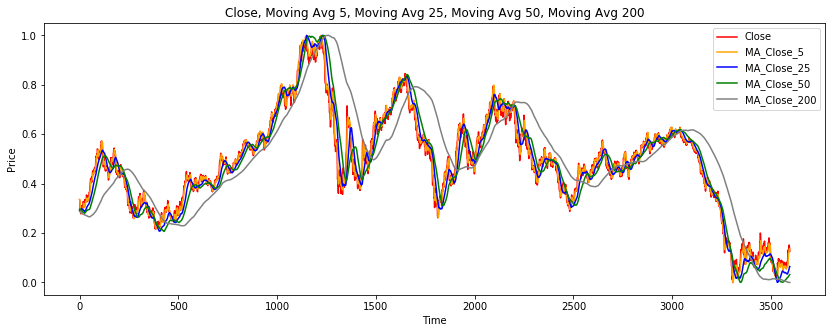

In [189]:
INICIO = 0
FIN = 3596

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3596, 18)


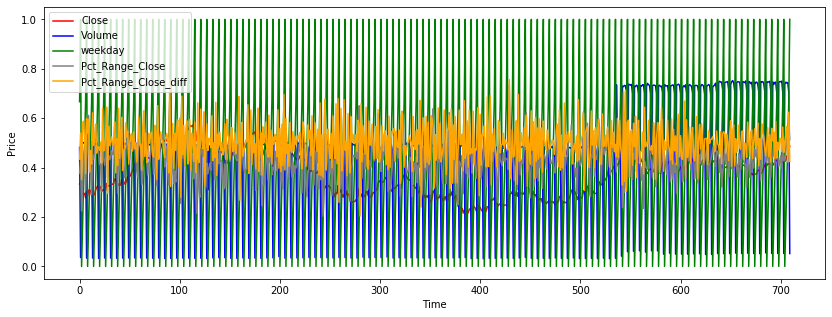

In [190]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3596, 18)


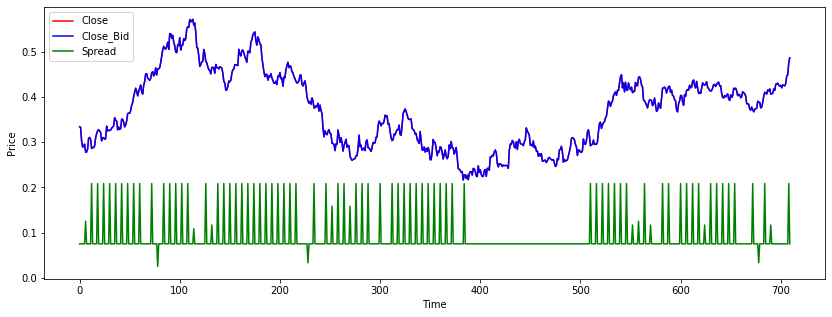

In [191]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [192]:
data_training_y

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

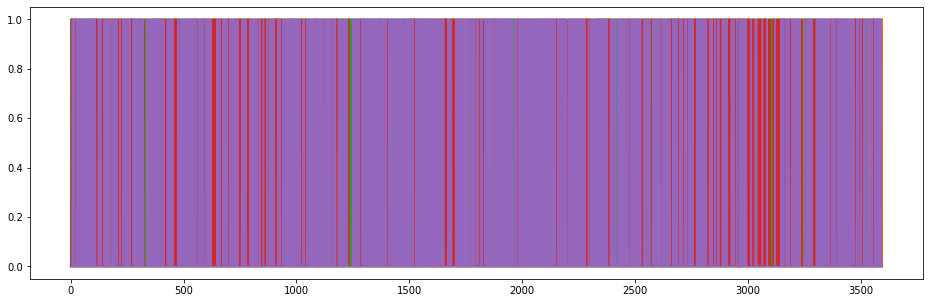

In [193]:
# Target para el entrenamiento
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [194]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    indx_start = i-RANGE
    X_train.append(data_training_array_scaled[indx_start:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(3591, 5, 18)
(3591, 5)


In [195]:
X_train_np[0,:,3]

array([0.33404984, 0.3327747 , 0.30339187, 0.2890921 , 0.29060405])

In [196]:
array = y_train_np[:RANGE]
uniques_y = uniques[array.argmax(1)]
print(uniques_y)

[-2.  0.  1.  2.  1.]


In [197]:
#
#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(5, 18)
(513, 18)
<bound method NDFrame.head of         Open     High      Low    Close       Volume  Open_Bid  High_Bid  \
0    1.12887  1.13117  1.11607  1.12843  450307.6563   1.12880   1.13115   
1    1.12843  1.13765  1.12742  1.13165  421344.6875   1.12839   1.13762   
2    1.13165  1.13340  1.12142  1.12580  363888.7188   1.13161   1.13338   
3    1.12395  1.12532  1.12160  1.12237   12776.7197   1.12347   1.12499   
4    1.12237  1.12393  1.11282  1.11765  264377.9688   1.12232   1.12389   
..       ...      ...      ...      ...          ...       ...       ...   
513  1.17944  1.18156  1.17941  1.18084    7998.0498   1.17886   1.18151   
514  1.18083  1.18084  1.17303  1.17318  214015.8594   1.18079   1.18079   
515  1.17321  1.17733  1.16963  1.17480  232977.6250   1.17319   1.17732   
516  1.17480  1.17883  1.17467  1.17569  206706.3750   1.17476   1.17877   
517  1.17569  1.17791  1.16993  1.17141  194164.4219   1.17565   1.17787   

     Low_Bid  Close_Bid   Volume_Bid   

In [198]:
last_range_train_y = data_training_y[-RANGE:]
last_range_train_y

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [199]:
last_range_train_y.shape

(5, 5)

In [200]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
print(data_val_y1.shape)
print(data_val_y1[:10])

(5, 5)
(513, 5)
(518, 5)
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [201]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[1.48545260e-01 1.45613877e-01 1.28435810e-01 1.45766540e-01
  2.00649308e-01 1.48657736e-01 1.45676335e-01 1.28510952e-01
  1.45780191e-01 1.54062253e-01 3.33333333e-02 3.33333333e-01
  4.29930732e-01 3.90693519e-01 1.24868686e-01 5.35366284e-02
  2.64637475e-02 3.33823403e-05]
 [1.47745652e-01 1.57322251e-01 1.49317438e-01 1.51632177e-01
  1.87694923e-01 1.47912539e-01 1.57368754e-01 1.49401804e-01
  1.51628890e-01 1.52214144e-01 4.16666667e-02 5.00000000e-01
  4.82121193e-01 5.40723669e-01 1.30648363e-01 5.69129463e-02
  2.77935059e-02 0.00000000e+00]
 [1.53597325e-01 1.49643148e-01 1.38278692e-01 1.40975663e-01
  1.61996359e-01 1.53765063e-01 1.49706334e-01 1.38358181e-01
  1.40204796e-01 1.25728725e-01 3.91666667e-01 6.66666667e-01
  3.52663674e-01 4.05204968e-01 1.34899005e-01 6.00533062e-02
  2.91191702e-02 9.58731573e-05]
 [1.39604194e-01 1.35043816e-01 1.38609854e-01 1.34727485e-01
  4.95306816e-03 1.38970174e-01 1.34544140e-01 1.38634272e-01
  1.34738722e-01 3.91927765e-03 3

In [202]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    indx_start = i-RANGE
    X_val.append(data_val_x2[indx_start:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(513, 5, 18)
(513, 5)


In [203]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(5, 18)
(829, 18)


(834, 18)

In [204]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:,:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
print(data_test_y1.shape)

(5, 5)
(829, 5)
(834, 5)


In [205]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[1.48545260e-01 1.45613877e-01 1.28435810e-01 1.45766540e-01
  2.00649308e-01 1.48657736e-01 1.45676335e-01 1.28510952e-01
  1.45780191e-01 1.54062253e-01 3.33333333e-02 3.33333333e-01
  4.29930732e-01 3.90693519e-01 1.24868686e-01 5.35366284e-02
  2.64637475e-02 3.33823403e-05]
 [1.47745652e-01 1.57322251e-01 1.49317438e-01 1.51632177e-01
  1.87694923e-01 1.47912539e-01 1.57368754e-01 1.49401804e-01
  1.51628890e-01 1.52214144e-01 4.16666667e-02 5.00000000e-01
  4.82121193e-01 5.40723669e-01 1.30648363e-01 5.69129463e-02
  2.77935059e-02 0.00000000e+00]
 [1.53597325e-01 1.49643148e-01 1.38278692e-01 1.40975663e-01
  1.61996359e-01 1.53765063e-01 1.49706334e-01 1.38358181e-01
  1.40204796e-01 1.25728725e-01 3.91666667e-01 6.66666667e-01
  3.52663674e-01 4.05204968e-01 1.34899005e-01 6.00533062e-02
  2.91191702e-02 9.58731573e-05]
 [1.39604194e-01 1.35043816e-01 1.38609854e-01 1.34727485e-01
  4.95306816e-03 1.38970174e-01 1.34544140e-01 1.38634272e-01
  1.34738722e-01 3.91927765e-03 3

In [206]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(829, 5, 18)
(829, 5)


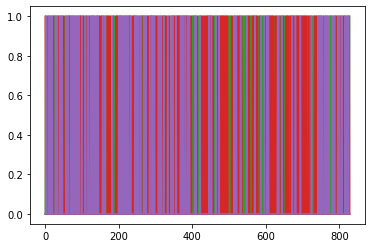

In [207]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

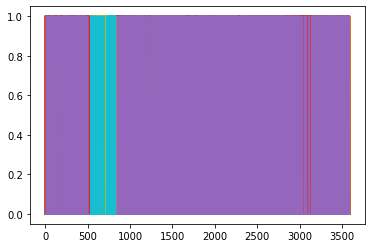

In [208]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [209]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

5
18


### Oversampling Inbalanced Class

In [210]:
#Check Current Shape
print(X_train_np.shape)
print(y_train_np.shape)

(3591, 5, 18)
(3591, 5)


In [211]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample


In [212]:
#X_over, y_over = oversample.fit_resample(X_train_np, y_train_np)

### BUILD LSTM MODEL 

In [213]:
model = Sequential()
model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
model.add(LSTM(units = 80, activation = 'relu'))
model.add(Dense(units = 5, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])


In [214]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 5)              480       
_________________________________________________________________
lstm_5 (LSTM)                (None, 80)                27520     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 405       
Total params: 28,405
Trainable params: 28,405
Non-trainable params: 0
_________________________________________________________________


In [215]:
history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)

Epoch 1/150
113/113 [==============================] - 1s 10ms/step - loss: 1.6073 - acc: 0.2136 - val_loss: 1.6124 - val_acc: 0.1813
Epoch 2/150
113/113 [==============================] - 1s 6ms/step - loss: 1.6042 - acc: 0.2242 - val_loss: 1.6078 - val_acc: 0.2105
Epoch 3/150
113/113 [==============================] - 1s 9ms/step - loss: 1.6017 - acc: 0.2203 - val_loss: 1.6125 - val_acc: 0.1813
Epoch 4/150
113/113 [==============================] - 1s 7ms/step - loss: 1.5936 - acc: 0.2320 - val_loss: 1.5981 - val_acc: 0.2008
Epoch 5/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5832 - acc: 0.2398 - val_loss: 1.5922 - val_acc: 0.2222
Epoch 6/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5675 - acc: 0.2721 - val_loss: 1.5820 - val_acc: 0.2515
Epoch 7/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5580 - acc: 0.2776 - val_loss: 1.5686 - val_acc: 0.2690
Epoch 8/150
113/113 [==============================] - 1s 8ms/step -

113/113 [==============================] - 1s 6ms/step - loss: 1.5041 - acc: 0.3049 - val_loss: 1.6217 - val_acc: 0.2300
Epoch 63/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5035 - acc: 0.3074 - val_loss: 1.6356 - val_acc: 0.2320
Epoch 64/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5028 - acc: 0.3122 - val_loss: 1.6310 - val_acc: 0.2515
Epoch 65/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5056 - acc: 0.3105 - val_loss: 1.6075 - val_acc: 0.2398
Epoch 66/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5027 - acc: 0.3097 - val_loss: 1.6613 - val_acc: 0.2359
Epoch 67/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5018 - acc: 0.3116 - val_loss: 1.6156 - val_acc: 0.2456
Epoch 68/150
113/113 [==============================] - 1s 6ms/step - loss: 1.5010 - acc: 0.3127 - val_loss: 1.6469 - val_acc: 0.2476
Epoch 69/150
113/113 [==============================] - 1s 6ms/step - loss:

113/113 [==============================] - 1s 6ms/step - loss: 1.4746 - acc: 0.3331 - val_loss: 1.7191 - val_acc: 0.2281
Epoch 124/150
113/113 [==============================] - 1s 8ms/step - loss: 1.4767 - acc: 0.3328 - val_loss: 1.6594 - val_acc: 0.2398
Epoch 125/150
113/113 [==============================] - 1s 8ms/step - loss: 1.4777 - acc: 0.3308 - val_loss: 1.7044 - val_acc: 0.2183
Epoch 126/150
113/113 [==============================] - 1s 7ms/step - loss: 1.4753 - acc: 0.3300 - val_loss: 1.6804 - val_acc: 0.2398
Epoch 127/150
113/113 [==============================] - 1s 7ms/step - loss: 1.4758 - acc: 0.3297 - val_loss: 1.7120 - val_acc: 0.2339
Epoch 128/150
113/113 [==============================] - 1s 9ms/step - loss: 1.4762 - acc: 0.3305 - val_loss: 1.7504 - val_acc: 0.2300
Epoch 129/150
113/113 [==============================] - 1s 11ms/step - loss: 1.4727 - acc: 0.3386 - val_loss: 1.7954 - val_acc: 0.2339
Epoch 130/150
113/113 [==============================] - 1s 9ms/step

In [216]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


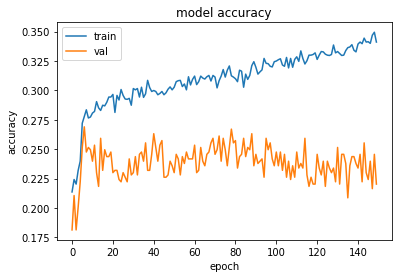

In [217]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

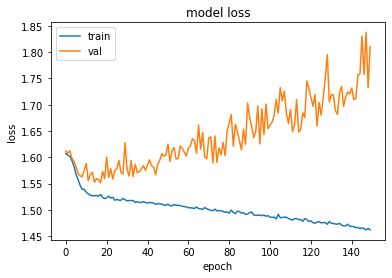

In [218]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [221]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/


In [222]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID 
print(file_name)



C-LSTM_1D_19F_Class_03


In [223]:
model.save(source_data + file_name + '.hdf5')

In [225]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath+'.hdf5')
FILENAME = os.path.splitext(file_name)[0]




/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/C-LSTM_1D_19F_Class_03


In [226]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

### CONFUSION MATRIX TEST

In [227]:
#TEST
y_test_pred = model.predict(X_test_np)
print(X_test_np.shape)

print(y_test_pred.shape)
print(y_test_np.shape)

(829, 5, 18)
(829, 5)
(829, 5)


In [228]:
ID = 4
print(y_test_pred[ID])
print(y_test_np[:ID])

[0.29036668 0.28048578 0.03244226 0.2850542  0.11165107]
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [231]:
uniques_y_test_pred = uniques[y_test_pred.argmax(1)]
uniques_y_test_np = uniques[y_test_np.argmax(1)]
print(uniques_y_test_pred)
print(uniques_y_test_pred.shape)
print(uniques_y_test_np)
print(uniques_y_test_np.shape)

[ 2.  2. -2. -1. -2.  1.  0. -1. -1.  1. -2.  1.  0. -1. -1.  1.  1. -1.
  0. -1.  1.  1. -2. -2.  0. -1.  1.  1. -2. -2.  0. -1. -1.  1. -2. -2.
  0. -1. -1.  1.  1.  1.  0. -1. -1.  1.  1.  1.  0. -1.  1.  1.  1.  1.
  0. -1.  1.  1. -2. -2.  0. -1.  1.  1. -2. -2.  0. -1.  1.  1. -2. -2.
  1. -1. -1.  1.  1.  1. -1.  1.  1.  2. -1.  0. -1.  1.  1.  1.  1.  0.
 -1.  1.  1.  1.  1.  0. -1. -1.  1.  1.  1.  0. -1. -1.  1.  1.  1.  0.
 -1.  1.  1.  1.  1.  0. -1.  1.  1.  1.  1.  0. -1.  1.  1.  1.  1.  0.
 -1.  1.  1.  2. -1.  0. -1.  1.  1.  2.  1.  0. -1.  1.  1.  2. -1.  0.
 -1.  1.  1.  1.  1.  0. -1.  1.  1.  1.  1.  0. -1.  1.  1.  1.  1.  0.
 -1.  1.  1.  1.  1.  0. -1.  1.  1.  1.  1.  0. -1.  1.  1.  2.  1.  0.
 -1.  1.  2.  1.  1.  0. -1.  1.  1.  2.  2.  0. -1.  1.  2.  2. -2.  0.
 -1.  1.  2.  2. -2.  0. -1.  1.  2.  2. -2.  0. -1.  1.  1.  2. -2.  0.
 -1.  1.  2.  2. -2.  0. -1.  1.  2.  2. -2.  0. -1.  1.  2.  2. -2.  0.
 -1.  1.  2.  2. -2.  0. -1.  1.  2.  2. -2.  0. -1

In [232]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [233]:
conf_matrix_test = confusion_matrix(uniques_y_test_np, uniques_y_test_pred)
conf_matrix_test

array([[20, 26,  2, 33, 43],
       [21, 57, 17, 44, 56],
       [15, 91, 38, 25, 32],
       [29, 58,  7, 28, 64],
       [22, 36,  0, 30, 35]])

In [234]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -2        0.187     0.161
1
   -1        0.213     0.292
2
    0        0.594     0.189
3
    1        0.175     0.151
4
    2        0.152     0.285


In [235]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: 0.26410527361162495
recall total: 0.2155486442387108


In [236]:
accuracy(conf_matrix_test)

0.2147165259348613

### CONFUSION MATRIX TRAIN

In [237]:
#TRAIN
y_train_pred = model.predict(X_train_np)
print(X_train_np.shape)

print(y_train_pred.shape)
print(y_train_np.shape)

(3591, 5, 18)
(3591, 5)
(3591, 5)


In [238]:
ID = 4
print(y_train_pred[:ID])
print(y_train_np[:ID])

[[0.27612227 0.17113468 0.1685345  0.13924116 0.24496736]
 [0.01817922 0.2841083  0.4448891  0.21739848 0.03542484]
 [0.2573087  0.26231223 0.13223618 0.17698655 0.17115626]
 [0.18301488 0.22516577 0.12099075 0.21583049 0.25499812]]
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [239]:
uniques_y_train_pred = uniques[y_train_pred.argmax(1)]
uniques_y_train_np = uniques[y_train_np.argmax(1)]
print(uniques_y_train_pred)
print(uniques_y_train_pred.shape)
print(uniques_y_train_np)
print(uniques_y_train_np.shape)

[-2.  0. -1. ... -1.  2.  2.]
(3591,)
[-2.  0.  1. ... -1. -2. -1.]
(3591,)


In [240]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [241]:
conf_matrix_train = confusion_matrix(uniques_y_train_np, uniques_y_train_pred)
conf_matrix_train

array([[378,  81,  23,  39, 269],
       [163, 142, 150,  58, 187],
       [109,  76, 239,  43, 142],
       [159, 105, 105,  98, 227],
       [233,  86,  18,  53, 408]])

In [242]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_train):9.3f}    {recall(indx, conf_matrix_train):6.3f}")

indx Value Precision Recall
0
   -2        0.363     0.478
1
   -1        0.290     0.203
2
    0        0.447     0.392
3
    1        0.337     0.141
4
    2        0.331     0.511


In [243]:
print("precision total:", precision_macro_average(conf_matrix_train))
print("recall total:", recall_macro_average(conf_matrix_train))

precision total: 0.35339176172723263
recall total: 0.3452546718939612


In [244]:
accuracy(conf_matrix_train)

0.35226956279587857

### TEST RESULTS TO CSV

In [245]:
print("data_test.shape: ", data_test.shape)


data_test.shape:  (829, 18)


In [246]:
data_test_res = data_test
data_test_res.reset_index(drop=True, inplace=True)
results_data_test = pd.DataFrame(data_test_res['Open'])
results_data_test['High'] = data_test_res['High']
results_data_test['Low'] = data_test_res['Low']
results_data_test['Close'] = data_test_res['Close']
results_data_test['Volume'] = data_test_res['Volume']
print(results_data_test)

        Open     High      Low    Close       Volume
0    1.17145  1.17390  1.16697  1.17336  209621.9375
1    1.17319  1.17438  1.17308  1.17427    8920.6504
2    1.17427  1.17562  1.17198  1.17414  152661.7344
3    1.17412  1.18259  1.17408  1.18138  214738.0938
4    1.18135  1.18694  1.17955  1.18644  216994.3750
..       ...      ...      ...      ...          ...
824  1.09019  1.09960  1.08970  1.09787  221915.4388
825  1.09788  1.10311  1.09342  1.10169  339215.8879
826  1.10168  1.10937  1.09919  1.10782  290715.4826
827  1.10780  1.11452  1.10702  1.11071  330692.3901
828  1.11213  1.11217  1.11028  1.11158   10126.4174

[829 rows x 5 columns]


In [247]:
uniques_y_test_pred[:]

array([ 2.,  2., -2., -1., -2.,  1.,  0., -1., -1.,  1., -2.,  1.,  0.,
       -1., -1.,  1.,  1., -1.,  0., -1.,  1.,  1., -2., -2.,  0., -1.,
        1.,  1., -2., -2.,  0., -1., -1.,  1., -2., -2.,  0., -1., -1.,
        1.,  1.,  1.,  0., -1., -1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,
        1.,  1.,  0., -1.,  1.,  1., -2., -2.,  0., -1.,  1.,  1., -2.,
       -2.,  0., -1.,  1.,  1., -2., -2.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  2., -1.,  0., -1.,  1.,  1.,  1.,  1.,  0., -1.,
        1.,  1.,  1.,  1.,  0., -1., -1.,  1.,  1.,  1.,  0., -1., -1.,
        1.,  1.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,
        1.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  2.,
       -1.,  0., -1.,  1.,  1.,  2.,  1.,  0., -1.,  1.,  1.,  2., -1.,
        0., -1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0.,
       -1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0., -1.,
        1.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  2.,  1.,  0., -1

In [248]:

uniques_y_test_pred_pd = pd.DataFrame({'Real_Class': uniques_y_test_pred[:]})
print(uniques_y_test_pred_pd)

     Real_Class
0           2.0
1           2.0
2          -2.0
3          -1.0
4          -2.0
..          ...
824         2.0
825        -2.0
826         2.0
827        -1.0
828        -1.0

[829 rows x 1 columns]


In [249]:
results_data_test['Real_Class'] = uniques_y_test_np
results_data_test['Predicted_Class'] = uniques_y_test_pred_pd

In [250]:
results_data_test.head(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.17145,1.17390,1.16697,1.17336,209621.9375,1.0,2.0
1,1.17319,1.17438,1.17308,1.17427,8920.6504,0.0,2.0
2,1.17427,1.17562,1.17198,1.17414,152661.7344,2.0,-2.0
3,1.17412,1.18259,1.17408,1.18138,214738.0938,2.0,-1.0
4,1.18135,1.18694,1.17955,1.18644,216994.3750,-1.0,-2.0
5,1.18641,1.18799,1.18254,1.18314,204817.6406,-1.0,1.0
6,1.18314,1.18750,1.18055,1.18223,199182.5000,0.0,0.0
7,1.18150,1.18183,1.18059,1.18149,7389.2700,-1.0,-1.0
8,1.18149,1.18199,1.17808,1.17948,187651.9063,-1.0,-1.0
9,1.17946,1.17953,1.17362,1.17716,192445.1250,1.0,1.0


### Test Result Save CSV File 

In [251]:
pwd = os.getcwd()
filename_path = os.path.join(pwd, r'../../../Results/LSTM/' + FILENAME + '_Test.csv')
print(filename_path)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/LSTM/C-LSTM_1D_19F_Class_03_Test.csv


In [252]:
#SAVE
results_data_test.to_csv(filename_path, header=True, index=False)

### TRAIN RESULTS TO CSV

In [253]:
print("data_train.shape: ", data_training.shape)


data_train.shape:  (3596, 18)


In [254]:
data_training_res = data_training
data_training_res.reset_index(drop=True, inplace=True)
results_data_train = pd.DataFrame(data_training_res['Open'])
results_data_train['High'] = data_training_res['High']
results_data_train['Low'] = data_training_res['Low']
results_data_train['Close'] = data_training_res['Close']
results_data_train['Volume'] = data_training_res['Volume']
print(results_data_train)
print(results_data_train.shape)
results_data_train = results_data_train.iloc[RANGE:]
results_data_train.reset_index(drop=True, inplace=True)
print(results_data_train.shape)

         Open     High      Low    Close        Volume
0     1.23655  1.23817  1.22801  1.23179  1.078729e+06
1     1.23158  1.23241  1.22967  1.23109  8.212280e+04
2     1.23140  1.23154  1.21310  1.21496  1.130388e+06
3     1.21495  1.21669  1.20594  1.20711  1.123270e+06
4     1.20718  1.21160  1.20519  1.20794  1.118725e+06
...       ...      ...      ...      ...           ...
3591  1.12887  1.13117  1.11607  1.12843  4.503077e+05
3592  1.12843  1.13765  1.12742  1.13165  4.213447e+05
3593  1.13165  1.13340  1.12142  1.12580  3.638887e+05
3594  1.12395  1.12532  1.12160  1.12237  1.277672e+04
3595  1.12237  1.12393  1.11282  1.11765  2.643780e+05

[3596 rows x 5 columns]
(3596, 5)
(3591, 5)


In [255]:
print(uniques_y_train_pred[:])
print(uniques_y_train_pred.shape)

[-2.  0. -1. ... -1.  2.  2.]
(3591,)


In [256]:

uniques_y_train_pred_pd = pd.DataFrame({'Real_Class': uniques_y_train_pred[:]})
print(uniques_y_train_pred_pd)
print(uniques_y_train_pred_pd.shape)


      Real_Class
0           -2.0
1            0.0
2           -1.0
3            2.0
4            2.0
...          ...
3586         2.0
3587        -2.0
3588        -1.0
3589         2.0
3590         2.0

[3591 rows x 1 columns]
(3591, 1)


In [257]:
results_data_train['Real_Class'] = uniques_y_train_np
results_data_train['Predicted_Class'] = uniques_y_train_pred_pd

In [258]:
results_data_train.head(10)
#results_data_train.tail(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.20780,1.21167,1.20465,1.21079,1.126558e+06,-2.0,-2.0
1,1.21063,1.21349,1.20005,1.20102,1.065118e+06,0.0,0.0
2,1.20131,1.20189,1.20019,1.20096,7.733910e+04,1.0,-1.0
3,1.20087,1.20685,1.19860,1.20468,1.124832e+06,2.0,2.0
4,1.20455,1.21946,1.20442,1.21778,1.117748e+06,1.0,2.0
5,1.21754,1.22208,1.21466,1.21889,1.106444e+06,-1.0,2.0
6,1.21899,1.21999,1.21408,1.21666,1.132577e+06,-2.0,-2.0
7,1.21663,1.21931,1.20414,1.20558,1.063896e+06,1.0,0.0
8,1.20628,1.20701,1.20509,1.20662,7.789710e+04,0.0,-2.0
9,1.20657,1.20802,1.20459,1.20650,1.110041e+06,1.0,-1.0


In [259]:
uniques_y_train_np[:20]

array([-2.,  0.,  1.,  2.,  1., -1., -2.,  1.,  0.,  1.,  2.,  2.,  1.,
        1., -1., -1., -2.,  1.,  0., -1.])

### Test Result Save CSV File 

In [263]:
pwd = os.getcwd()
filename_path = os.path.join(pwd, r'../../../Results/LSTM/' + FILENAME + '_Train.csv')
print(filename_path)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/LSTM/C-LSTM_1D_19F_Class_03_Train.csv


In [264]:
#Save
results_data_train.to_csv(filename_path, header=True, index=False)